# Model Specification
This example solve a standard AR(1) process but with multiple noise measurements. If there are many parameters, we need more data for proper estimation.

In [1]:

import numpy as np
import pandas as pd
import linkalman
import scipy
from linkalman.models import BaseConstantModel as BCM
from linkalman.core.utils import gen_PSD
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import datetime
from copy import deepcopy
%matplotlib inline 



/usr/local/Cellar/python/3.7.2_2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Unrestricted Parametrization of Covariance Matrices
Sometime we want to let a covariance matrix (e.g. `R`) to be fully parametrized without restriction (e.g. PSD of `R`). Here I use `linkalman.core.utils.gen_PSD` to achieve this. It uses Cholesky decomposition with strictly non-negative diagonal values to achieve unique and restriction-free parametrizaion.   

In [2]:
def my_f(theta):
    """
    AR(1) model. Introduce noise and 
    """
    # Define theta
    f = 1 / (1 + np.exp(theta[3]))
    sigma = np.exp(theta[4]) 
    # Generate F
    F = np.array([[f]])
    # Generate Q
    Q = np.array([[sigma]]) 
    # Generate R, set to 0 to be consistent with AR(1) process
    R = gen_PSD(theta[0:3], 2)  # need three parameters to define a 2-by-2 R
    # Generate H
    H = np.array([[1], [theta[5]]])  # enforce one coefficient to be 1 to make the system more identifiable.
    # Generate D
    D = np.array([[theta[6]], [theta[7]]])
    # Collect system matrices
    M = {'F': F, 'Q': Q, 'H': H, 'R': R, 'D': D}

    return M



In [3]:
def my_solver(param, obj_func, verbose=False, **kwargs):
    """
    Simple solver for LLY
    """
    obj_ = lambda x: -obj_func(x)
    def disp_f(x):
        print('theta is {}. Function value is: {}.'.format(x, obj_func(x)))
    callbackf = None
    if verbose:
        callbackf = disp_f
    res = minimize(obj_, param, callback=callbackf, **kwargs)
    theta_opt = np.array(res.x)
    fval_opt = res.fun
    return theta_opt, fval_opt

In [4]:
# Initialize the model
x = 1  # used to calculate stationary mean
model = BCM()
model.set_f(my_f, x_0=x * np.ones([1, 1]))
model.set_solver(my_solver, method='nelder-mead', 
        options={'xatol': 1e-8, 'disp': True, 'maxiter': 10000}, verbose=True) 

# Generate Synthetic Data
Same as the standard setup, but I cross off some measurements during training period and see how `linkalman` handles them. I generate some partial missing data for each of the measurements.

In [5]:
# Some initial parameters
theta = np.array([0.1, 0.3, 0.1, -0.5, -0.1, 2, 4, 5])
T = 3000  
train_split_ratio = 0.7
forecast_cutoff_ratio = 0.8  

missing_range_1st = [0.3, 0.4]  # range of missing for the first measurement
missing_range_2nd_end = 0.5  # end ratio of missing for the second measurement

# Split train data
train_split_t = np.floor(T * train_split_ratio).astype(int)

# Generate missing data for forcasting
forecast_t = np.floor(T * forecast_cutoff_ratio).astype(int)

# If we want AR(1) with non-zero stationary mean, we should proivde a constant 
x_col = ['const']
Xt = pd.DataFrame({x_col[0]: x * np.ones(T)})  # use x to ensure constant model

# Build simulated data
df, y_col, xi_col = model.simulated_data(input_theta=theta, Xt=Xt)

# Store fully visible y for comparison later
df['y_0_vis'] = df.y_0.copy()  
df['y_1_vis'] = df.y_1.copy()

# Insert some missingness
missing_start1_t = np.floor(T * missing_range_1st[0]).astype(int)
missing_end1_t = np.floor(T * missing_range_1st[1]).astype(int)
missing_start2_t = missing_end1_t 
missing_end2_t = np.floor(T * missing_range_2nd_end).astype(int)

is_missing1 = (df.index >= missing_start1_t) & (df.index < missing_end1_t)
is_missing2 = (df.index >= missing_end1_t) & (df.index < missing_end2_t)
df.loc[is_missing1, ['y_0']] = np.nan
df.loc[is_missing2, ['y_1']] = np.nan

# Splits models into three groups
is_train = df.index < train_split_t
is_test = (~is_train) & (df.index < forecast_t)
is_forecast = ~(is_train | is_test)

# Create a training and test data
df_train = df.loc[is_train].copy()
df_test = df.copy()  

# Create an offset
df_test.loc[is_forecast, ['y_0', 'y_1']] = np.nan

# Fit and Predict

In [6]:
# Fit data using LLY:
start_time = datetime.datetime.now()
theta_init = np.random.rand(len(theta))
model.fit(df_train, theta_init, y_col=y_col, x_col=x_col, 
              method='LLY')
end_time = datetime.datetime.now()
print('Runtime: {} seconds.'.format((end_time - start_time).seconds))

theta is [0.7786495  0.26038441 0.97438546 0.94241718 0.82924693 0.27531559
 0.81788946 0.4331347 ]. Function value is: -15570.097773332298.
theta is [0.7786495  0.26038441 0.97438546 0.94241718 0.82924693 0.27531559
 0.81788946 0.4331347 ]. Function value is: -15570.097773332298.
theta is [0.7786495  0.26038441 0.97438546 0.94241718 0.82924693 0.27531559
 0.81788946 0.4331347 ]. Function value is: -15570.097773332298.
theta is [0.7786495  0.26038441 0.97438546 0.94241718 0.82924693 0.27531559
 0.81788946 0.4331347 ]. Function value is: -15570.097773332298.
theta is [0.7786495  0.26038441 0.97438546 0.94241718 0.82924693 0.27531559
 0.81788946 0.4331347 ]. Function value is: -15570.097773332298.
theta is [0.75904544 0.26155251 0.98108595 0.89927674 0.77822375 0.29106927
 0.83018476 0.45791887]. Function value is: -15406.310502448612.
theta is [0.75904544 0.26155251 0.98108595 0.89927674 0.77822375 0.29106927
 0.83018476 0.45791887]. Function value is: -15406.310502448612.
theta is [0.7

theta is [ 0.34385842  0.17840644  1.63350913 -0.76998141  1.33892823  0.22613887
  1.39064008  0.80092781]. Function value is: -11639.173804414.
theta is [ 0.23411079  0.17181199  1.73348472 -0.94896189  1.30977893  0.22874555
  1.52136313  0.83649199]. Function value is: -11582.174935204088.
theta is [ 0.23411079  0.17181199  1.73348472 -0.94896189  1.30977893  0.22874555
  1.52136313  0.83649199]. Function value is: -11582.174935204088.
theta is [ 0.23411079  0.17181199  1.73348472 -0.94896189  1.30977893  0.22874555
  1.52136313  0.83649199]. Function value is: -11582.174935204088.
theta is [ 0.23411079  0.17181199  1.73348472 -0.94896189  1.30977893  0.22874555
  1.52136313  0.83649199]. Function value is: -11582.174935204088.
theta is [ 0.23411079  0.17181199  1.73348472 -0.94896189  1.30977893  0.22874555
  1.52136313  0.83649199]. Function value is: -11582.174935204088.
theta is [ 0.23411079  0.17181199  1.73348472 -0.94896189  1.30977893  0.22874555
  1.52136313  0.83649199]. 

theta is [-2.05023025  0.58748983  0.63602484 -0.6523329   1.74984244  1.02496545
  1.11337957  2.02075496]. Function value is: -8600.946658594517.
theta is [-2.05023025  0.58748983  0.63602484 -0.6523329   1.74984244  1.02496545
  1.11337957  2.02075496]. Function value is: -8600.946658594517.
theta is [-2.05023025  0.58748983  0.63602484 -0.6523329   1.74984244  1.02496545
  1.11337957  2.02075496]. Function value is: -8600.946658594517.
theta is [-2.05023025  0.58748983  0.63602484 -0.6523329   1.74984244  1.02496545
  1.11337957  2.02075496]. Function value is: -8600.946658594517.
theta is [-2.05023025  0.58748983  0.63602484 -0.6523329   1.74984244  1.02496545
  1.11337957  2.02075496]. Function value is: -8600.946658594517.
theta is [-2.05023025  0.58748983  0.63602484 -0.6523329   1.74984244  1.02496545
  1.11337957  2.02075496]. Function value is: -8600.946658594517.
theta is [-2.05023025  0.58748983  0.63602484 -0.6523329   1.74984244  1.02496545
  1.11337957  2.02075496]. Fun

theta is [-2.05055058  0.47425212  0.48000098 -1.0830845   1.11350679  1.28661522
  2.13261236  2.35179409]. Function value is: -8137.2278322077855.
theta is [-2.05055058  0.47425212  0.48000098 -1.0830845   1.11350679  1.28661522
  2.13261236  2.35179409]. Function value is: -8137.2278322077855.
theta is [-2.05055058  0.47425212  0.48000098 -1.0830845   1.11350679  1.28661522
  2.13261236  2.35179409]. Function value is: -8137.2278322077855.
theta is [-2.05055058  0.47425212  0.48000098 -1.0830845   1.11350679  1.28661522
  2.13261236  2.35179409]. Function value is: -8137.2278322077855.
theta is [-2.05055058  0.47425212  0.48000098 -1.0830845   1.11350679  1.28661522
  2.13261236  2.35179409]. Function value is: -8137.2278322077855.
theta is [-2.05055058  0.47425212  0.48000098 -1.0830845   1.11350679  1.28661522
  2.13261236  2.35179409]. Function value is: -8137.2278322077855.
theta is [-2.05055058  0.47425212  0.48000098 -1.0830845   1.11350679  1.28661522
  2.13261236  2.35179409

theta is [-0.19591596  0.08050488  0.57433866 -2.01416392  1.00048853  1.1513581
  2.51414615  3.01987717]. Function value is: -7894.874156490998.
theta is [-0.19591596  0.08050488  0.57433866 -2.01416392  1.00048853  1.1513581
  2.51414615  3.01987717]. Function value is: -7894.874156490998.
theta is [-0.57722907  0.17109411  0.54217112 -1.52280821  0.90627578  1.18592518
  2.3510416   2.79409522]. Function value is: -7867.943870505549.
theta is [-0.09899988  0.0552212   0.57659956 -1.76561307  0.74996575  1.17407859
  2.59479364  2.95369842]. Function value is: -7820.654985980328.
theta is [-0.09899988  0.0552212   0.57659956 -1.76561307  0.74996575  1.17407859
  2.59479364  2.95369842]. Function value is: -7820.654985980328.
theta is [-0.09899988  0.0552212   0.57659956 -1.76561307  0.74996575  1.17407859
  2.59479364  2.95369842]. Function value is: -7820.654985980328.
theta is [-0.09899988  0.0552212   0.57659956 -1.76561307  0.74996575  1.17407859
  2.59479364  2.95369842]. Funct

theta is [-0.05220189  0.01828103  0.46377283 -1.58879944  0.17863971  1.40046375
  2.9449838   3.30564622]. Function value is: -7568.422848569.
theta is [-0.05220189  0.01828103  0.46377283 -1.58879944  0.17863971  1.40046375
  2.9449838   3.30564622]. Function value is: -7568.422848569.
theta is [-0.05220189  0.01828103  0.46377283 -1.58879944  0.17863971  1.40046375
  2.9449838   3.30564622]. Function value is: -7568.422848569.
theta is [-0.05220189  0.01828103  0.46377283 -1.58879944  0.17863971  1.40046375
  2.9449838   3.30564622]. Function value is: -7568.422848569.
theta is [-7.74167670e-03 -5.17704902e-04  4.52450220e-01 -1.77250334e+00
  1.41071478e-01  1.43616195e+00  3.08430002e+00  3.43655959e+00]. Function value is: -7564.113188677025.
theta is [ 0.01198546 -0.01233182  0.42343007 -1.68472603  0.00858402  1.47039217
  3.16963114  3.44411514]. Function value is: -7561.916426484292.
theta is [-0.07841911  0.01647902  0.44113932 -1.7319592   0.15751222  1.44241067
  3.055847

theta is [-0.00854519 -0.01439309  0.27740918 -1.680283   -0.05859889  1.5910162
  3.18867094  3.73693532]. Function value is: -7485.155102265768.
theta is [-0.00854519 -0.01439309  0.27740918 -1.680283   -0.05859889  1.5910162
  3.18867094  3.73693532]. Function value is: -7485.155102265768.
theta is [-0.00854519 -0.01439309  0.27740918 -1.680283   -0.05859889  1.5910162
  3.18867094  3.73693532]. Function value is: -7485.155102265768.
theta is [-0.00854519 -0.01439309  0.27740918 -1.680283   -0.05859889  1.5910162
  3.18867094  3.73693532]. Function value is: -7485.155102265768.
theta is [-0.00854519 -0.01439309  0.27740918 -1.680283   -0.05859889  1.5910162
  3.18867094  3.73693532]. Function value is: -7485.155102265768.
theta is [-0.00854519 -0.01439309  0.27740918 -1.680283   -0.05859889  1.5910162
  3.18867094  3.73693532]. Function value is: -7485.155102265768.
theta is [-0.00854519 -0.01439309  0.27740918 -1.680283   -0.05859889  1.5910162
  3.18867094  3.73693532]. Function v

theta is [-0.00827244 -0.01488257  0.21143509 -1.60587128  0.00564026  1.57967276
  3.1527833   3.68821224]. Function value is: -7480.007423460342.
theta is [-1.02252525e-03 -1.53460145e-02  2.30528749e-01 -1.65271759e+00
  6.87690165e-03  1.57992595e+00  3.16154833e+00  3.71312267e+00]. Function value is: -7479.916874475033.
theta is [-1.02252525e-03 -1.53460145e-02  2.30528749e-01 -1.65271759e+00
  6.87690165e-03  1.57992595e+00  3.16154833e+00  3.71312267e+00]. Function value is: -7479.916874475033.
theta is [-2.80554057e-03 -1.17890475e-02  2.25772544e-01 -1.61089167e+00
  2.32455717e-02  1.57225156e+00  3.12792469e+00  3.69156718e+00]. Function value is: -7479.007781308397.
theta is [-2.80554057e-03 -1.17890475e-02  2.25772544e-01 -1.61089167e+00
  2.32455717e-02  1.57225156e+00  3.12792469e+00  3.69156718e+00]. Function value is: -7479.007781308397.
theta is [-2.80554057e-03 -1.17890475e-02  2.25772544e-01 -1.61089167e+00
  2.32455717e-02  1.57225156e+00  3.12792469e+00  3.691567

theta is [ 0.08632004  0.46291239  0.2835996  -0.74387859 -0.14484385  1.80847261
  4.10690522  4.91582826]. Function value is: -7252.515321543981.
theta is [ 0.08632004  0.46291239  0.2835996  -0.74387859 -0.14484385  1.80847261
  4.10690522  4.91582826]. Function value is: -7252.515321543981.
theta is [ 0.08632004  0.46291239  0.2835996  -0.74387859 -0.14484385  1.80847261
  4.10690522  4.91582826]. Function value is: -7252.515321543981.
theta is [ 0.08632004  0.46291239  0.2835996  -0.74387859 -0.14484385  1.80847261
  4.10690522  4.91582826]. Function value is: -7252.515321543981.
theta is [ 0.08632004  0.46291239  0.2835996  -0.74387859 -0.14484385  1.80847261
  4.10690522  4.91582826]. Function value is: -7252.515321543981.
theta is [ 0.08632004  0.46291239  0.2835996  -0.74387859 -0.14484385  1.80847261
  4.10690522  4.91582826]. Function value is: -7252.515321543981.
theta is [ 0.08632004  0.46291239  0.2835996  -0.74387859 -0.14484385  1.80847261
  4.10690522  4.91582826]. Fun

theta is [ 0.16282745  0.47500874  0.27816297 -0.63411387 -0.18058552  1.832325
  4.06134374  5.04303404]. Function value is: -7218.501887892061.
theta is [ 0.16407581  0.48603111  0.28708022 -0.621546   -0.19415338  1.84383671
  4.06863433  5.09577841]. Function value is: -7218.309239082008.
theta is [ 0.16407581  0.48603111  0.28708022 -0.621546   -0.19415338  1.84383671
  4.06863433  5.09577841]. Function value is: -7218.309239082008.
theta is [ 0.16407581  0.48603111  0.28708022 -0.621546   -0.19415338  1.84383671
  4.06863433  5.09577841]. Function value is: -7218.309239082008.
theta is [ 0.15668664  0.47303282  0.27262555 -0.64260098 -0.1670683   1.83091553
  4.04396071  5.03933001]. Function value is: -7218.133202593752.
theta is [ 0.15668664  0.47303282  0.27262555 -0.64260098 -0.1670683   1.83091553
  4.04396071  5.03933001]. Function value is: -7218.133202593752.
theta is [ 0.15704941  0.45789347  0.27238069 -0.68322791 -0.20518655  1.84229482
  4.05671941  5.04587398]. Funct

theta is [ 0.16161114  0.47227322  0.24628998 -0.64781273 -0.22065165  1.86831382
  4.09200676  5.1333942 ]. Function value is: -7216.277458452285.
theta is [ 0.16161114  0.47227322  0.24628998 -0.64781273 -0.22065165  1.86831382
  4.09200676  5.1333942 ]. Function value is: -7216.277458452285.
theta is [ 0.16161114  0.47227322  0.24628998 -0.64781273 -0.22065165  1.86831382
  4.09200676  5.1333942 ]. Function value is: -7216.277458452285.
theta is [ 0.16161114  0.47227322  0.24628998 -0.64781273 -0.22065165  1.86831382
  4.09200676  5.1333942 ]. Function value is: -7216.277458452285.
theta is [ 0.16105055  0.47127838  0.24786814 -0.65155942 -0.22091345  1.86731597
  4.0918617   5.12924582]. Function value is: -7216.276819879544.
theta is [ 0.16202959  0.47068913  0.24794755 -0.65399167 -0.22475987  1.86934513
  4.09268291  5.13497307]. Function value is: -7216.273522516481.
theta is [ 0.16202959  0.47068913  0.24794755 -0.65399167 -0.22475987  1.86934513
  4.09268291  5.13497307]. Fun

theta is [ 0.16067696  0.46943558  0.24737954 -0.65173698 -0.22482456  1.86800704
  4.08879737  5.1269246 ]. Function value is: -7216.261505714286.
theta is [ 0.16067696  0.46943558  0.24737954 -0.65173698 -0.22482456  1.86800704
  4.08879737  5.1269246 ]. Function value is: -7216.261505714286.
theta is [ 0.16067696  0.46943558  0.24737954 -0.65173698 -0.22482456  1.86800704
  4.08879737  5.1269246 ]. Function value is: -7216.261505714286.
theta is [ 0.16067696  0.46943558  0.24737954 -0.65173698 -0.22482456  1.86800704
  4.08879737  5.1269246 ]. Function value is: -7216.261505714286.
theta is [ 0.16075472  0.46962708  0.24704553 -0.6510383  -0.22560747  1.86851978
  4.08968944  5.12830577]. Function value is: -7216.2613303219705.
theta is [ 0.16075472  0.46962708  0.24704553 -0.6510383  -0.22560747  1.86851978
  4.08968944  5.12830577]. Function value is: -7216.2613303219705.
theta is [ 0.16075472  0.46962708  0.24704553 -0.6510383  -0.22560747  1.86851978
  4.08968944  5.12830577]. F

theta is [ 0.16056021  0.46932377  0.24738839 -0.65016772 -0.22640553  1.86832992
  4.08852663  5.12617564]. Function value is: -7216.254622513281.
theta is [ 0.16056021  0.46932377  0.24738839 -0.65016772 -0.22640553  1.86832992
  4.08852663  5.12617564]. Function value is: -7216.254622513281.
theta is [ 0.16031876  0.46930728  0.24786121 -0.65222861 -0.22683909  1.86867239
  4.08954695  5.12731311]. Function value is: -7216.252966585412.
theta is [ 0.16031876  0.46930728  0.24786121 -0.65222861 -0.22683909  1.86867239
  4.08954695  5.12731311]. Function value is: -7216.252966585412.
theta is [ 0.15962981  0.46947664  0.24811867 -0.65001605 -0.22623501  1.86801151
  4.08778865  5.12447128]. Function value is: -7216.250380747563.
theta is [ 0.15962981  0.46947664  0.24811867 -0.65001605 -0.22623501  1.86801151
  4.08778865  5.12447128]. Function value is: -7216.250380747563.
theta is [ 0.15962981  0.46947664  0.24811867 -0.65001605 -0.22623501  1.86801151
  4.08778865  5.12447128]. Fun

theta is [ 0.15810215  0.47340423  0.24591247 -0.64436705 -0.23084337  1.87670647
  4.08605986  5.13208564]. Function value is: -7216.021909500877.
theta is [ 0.15810215  0.47340423  0.24591247 -0.64436705 -0.23084337  1.87670647
  4.08605986  5.13208564]. Function value is: -7216.021909500877.
theta is [ 0.15810215  0.47340423  0.24591247 -0.64436705 -0.23084337  1.87670647
  4.08605986  5.13208564]. Function value is: -7216.021909500877.
theta is [ 0.15810215  0.47340423  0.24591247 -0.64436705 -0.23084337  1.87670647
  4.08605986  5.13208564]. Function value is: -7216.021909500877.
theta is [ 0.15762763  0.46995025  0.24517417 -0.64594657 -0.23651839  1.8779707
  4.07900916  5.1217262 ]. Function value is: -7215.955291321952.
theta is [ 0.15762763  0.46995025  0.24517417 -0.64594657 -0.23651839  1.8779707
  4.07900916  5.1217262 ]. Function value is: -7215.955291321952.
theta is [ 0.15762763  0.46995025  0.24517417 -0.64594657 -0.23651839  1.8779707
  4.07900916  5.1217262 ]. Functi

theta is [ 0.16804814  0.49078426  0.22372053 -0.59157624 -0.23262997  1.92325994
  4.0326649   5.03369322]. Function value is: -7214.211801833004.
theta is [ 0.16804814  0.49078426  0.22372053 -0.59157624 -0.23262997  1.92325994
  4.0326649   5.03369322]. Function value is: -7214.211801833004.
theta is [ 0.16804814  0.49078426  0.22372053 -0.59157624 -0.23262997  1.92325994
  4.0326649   5.03369322]. Function value is: -7214.211801833004.
theta is [ 0.16804814  0.49078426  0.22372053 -0.59157624 -0.23262997  1.92325994
  4.0326649   5.03369322]. Function value is: -7214.211801833004.
theta is [ 0.16804814  0.49078426  0.22372053 -0.59157624 -0.23262997  1.92325994
  4.0326649   5.03369322]. Function value is: -7214.211801833004.
theta is [ 0.16804814  0.49078426  0.22372053 -0.59157624 -0.23262997  1.92325994
  4.0326649   5.03369322]. Function value is: -7214.211801833004.
theta is [ 0.17199954  0.49783408  0.22655196 -0.56831314 -0.24243094  1.93131425
  4.03464932  5.0237107 ]. Fun

theta is [ 0.18307759  0.4981398   0.22410462 -0.61602665 -0.28592467  1.97698891
  4.0475961   5.05499549]. Function value is: -7213.137935984748.
theta is [ 0.18331499  0.49826919  0.22518724 -0.6203623  -0.28290877  1.97456938
  4.05329592  5.05871458]. Function value is: -7213.136587040043.
theta is [ 0.18331499  0.49826919  0.22518724 -0.6203623  -0.28290877  1.97456938
  4.05329592  5.05871458]. Function value is: -7213.136587040043.
theta is [ 0.18356013  0.49869467  0.22327332 -0.62327912 -0.28581369  1.98196664
  4.04697553  5.04628115]. Function value is: -7213.135626713694.
theta is [ 0.18356013  0.49869467  0.22327332 -0.62327912 -0.28581369  1.98196664
  4.04697553  5.04628115]. Function value is: -7213.135626713694.
theta is [ 0.18210525  0.49633815  0.22670889 -0.62571462 -0.28461905  1.97385883
  4.05151193  5.05480366]. Function value is: -7213.127816740288.
theta is [ 0.18210525  0.49633815  0.22670889 -0.62571462 -0.28461905  1.97385883
  4.05151193  5.05480366]. Fun

theta is [ 0.18248209  0.49441865  0.21911247 -0.62417402 -0.2863597   1.97742306
  4.0492414   5.05039711]. Function value is: -7213.061666463482.
theta is [ 0.18260589  0.49225905  0.21791043 -0.62670418 -0.28907904  1.97778285
  4.048261    5.04780391]. Function value is: -7213.059371999181.
theta is [ 0.18260589  0.49225905  0.21791043 -0.62670418 -0.28907904  1.97778285
  4.048261    5.04780391]. Function value is: -7213.059371999181.
theta is [ 0.18260589  0.49225905  0.21791043 -0.62670418 -0.28907904  1.97778285
  4.048261    5.04780391]. Function value is: -7213.059371999181.
theta is [ 0.18260589  0.49225905  0.21791043 -0.62670418 -0.28907904  1.97778285
  4.048261    5.04780391]. Function value is: -7213.059371999181.
theta is [ 0.18260589  0.49225905  0.21791043 -0.62670418 -0.28907904  1.97778285
  4.048261    5.04780391]. Function value is: -7213.059371999181.
theta is [ 0.18260589  0.49225905  0.21791043 -0.62670418 -0.28907904  1.97778285
  4.048261    5.04780391]. Fun

theta is [ 0.18223621  0.49316036  0.21752556 -0.62518684 -0.28845593  1.97872607
  4.04764864  5.04690108]. Function value is: -7213.056668215229.
theta is [ 0.18223621  0.49316036  0.21752556 -0.62518684 -0.28845593  1.97872607
  4.04764864  5.04690108]. Function value is: -7213.056668215229.
theta is [ 0.18223621  0.49316036  0.21752556 -0.62518684 -0.28845593  1.97872607
  4.04764864  5.04690108]. Function value is: -7213.056668215229.
theta is [ 0.18214251  0.49301618  0.21767984 -0.62529517 -0.28872555  1.97866259
  4.04739184  5.04647156]. Function value is: -7213.0566524496435.
theta is [ 0.18214251  0.49301618  0.21767984 -0.62529517 -0.28872555  1.97866259
  4.04739184  5.04647156]. Function value is: -7213.0566524496435.
theta is [ 0.18215701  0.49296916  0.2177761  -0.62544391 -0.28846443  1.97831416
  4.04766825  5.04687509]. Function value is: -7213.05663769581.
theta is [ 0.18215701  0.49296916  0.2177761  -0.62544391 -0.28846443  1.97831416
  4.04766825  5.04687509]. Fu

theta is [ 0.18205196  0.49295909  0.21774872 -0.62551518 -0.28808585  1.9781517
  4.0474285   5.0466802 ]. Function value is: -7213.0565518977455.
theta is [ 0.18205196  0.49295909  0.21774872 -0.62551518 -0.28808585  1.9781517
  4.0474285   5.0466802 ]. Function value is: -7213.0565518977455.
theta is [ 0.18205196  0.49295909  0.21774872 -0.62551518 -0.28808585  1.9781517
  4.0474285   5.0466802 ]. Function value is: -7213.0565518977455.
theta is [ 0.18205196  0.49295909  0.21774872 -0.62551518 -0.28808585  1.9781517
  4.0474285   5.0466802 ]. Function value is: -7213.0565518977455.
theta is [ 0.18203924  0.49290965  0.21771553 -0.62553711 -0.28804419  1.97809193
  4.04736857  5.04658021]. Function value is: -7213.056551773793.
theta is [ 0.18203924  0.49290965  0.21771553 -0.62553711 -0.28804419  1.97809193
  4.04736857  5.04658021]. Function value is: -7213.056551773793.
theta is [ 0.18203924  0.49290965  0.21771553 -0.62553711 -0.28804419  1.97809193
  4.04736857  5.04658021]. Fun

theta is [ 0.18204031  0.49291836  0.21772138 -0.62557191 -0.28807246  1.97812916
  4.04738848  5.04658513]. Function value is: -7213.05654933492.
theta is [ 0.18204031  0.49291836  0.21772138 -0.62557191 -0.28807246  1.97812916
  4.04738848  5.04658513]. Function value is: -7213.05654933492.
theta is [ 0.18204031  0.49291836  0.21772138 -0.62557191 -0.28807246  1.97812916
  4.04738848  5.04658513]. Function value is: -7213.05654933492.
theta is [ 0.18203628  0.49293098  0.2177381  -0.62554598 -0.28809875  1.97814101
  4.04739696  5.04661698]. Function value is: -7213.05654904725.
theta is [ 0.18203628  0.49293098  0.2177381  -0.62554598 -0.28809875  1.97814101
  4.04739696  5.04661698]. Function value is: -7213.05654904725.
theta is [ 0.18203626  0.49294007  0.21772951 -0.62553404 -0.28806235  1.97813276
  4.04740179  5.04662229]. Function value is: -7213.056548816213.
theta is [ 0.18203646  0.49292671  0.21772198 -0.62552277 -0.28809082  1.97813733
  4.04738078  5.04658184]. Function

theta is [ 0.18210724  0.49293853  0.21766175 -0.62537807 -0.28808083  1.9782213
  4.04718302  5.04633829]. Function value is: -7213.056502225706.
theta is [ 0.18210724  0.49293853  0.21766175 -0.62537807 -0.28808083  1.9782213
  4.04718302  5.04633829]. Function value is: -7213.056502225706.
theta is [ 0.18210724  0.49293853  0.21766175 -0.62537807 -0.28808083  1.9782213
  4.04718302  5.04633829]. Function value is: -7213.056502225706.
theta is [ 0.18210724  0.49293853  0.21766175 -0.62537807 -0.28808083  1.9782213
  4.04718302  5.04633829]. Function value is: -7213.056502225706.
theta is [ 0.18210724  0.49293853  0.21766175 -0.62537807 -0.28808083  1.9782213
  4.04718302  5.04633829]. Function value is: -7213.056502225706.
theta is [ 0.18210724  0.49293853  0.21766175 -0.62537807 -0.28808083  1.9782213
  4.04718302  5.04633829]. Function value is: -7213.056502225706.
theta is [ 0.18210724  0.49293853  0.21766175 -0.62537807 -0.28808083  1.9782213
  4.04718302  5.04633829]. Function v

theta is [ 0.18205183  0.49287622  0.21779661 -0.62527683 -0.28735083  1.97759728
  4.04704136  5.04582939]. Function value is: -7213.056337166205.
theta is [ 0.18212343  0.49300958  0.21786462 -0.62530455 -0.28748003  1.9778357
  4.04713903  5.04621103]. Function value is: -7213.056315493754.
theta is [ 0.18206674  0.49289947  0.21779825 -0.62525461 -0.28745849  1.97760461
  4.04728411  5.04649145]. Function value is: -7213.056246876803.
theta is [ 0.18206674  0.49289947  0.21779825 -0.62525461 -0.28745849  1.97760461
  4.04728411  5.04649145]. Function value is: -7213.056246876803.
theta is [ 0.18206674  0.49289947  0.21779825 -0.62525461 -0.28745849  1.97760461
  4.04728411  5.04649145]. Function value is: -7213.056246876803.
theta is [ 0.18206674  0.49289947  0.21779825 -0.62525461 -0.28745849  1.97760461
  4.04728411  5.04649145]. Function value is: -7213.056246876803.
theta is [ 0.1820797   0.49276935  0.21780874 -0.62517725 -0.28721729  1.97735882
  4.04688772  5.04577017]. Func

theta is [ 0.18207467  0.49250571  0.21787321 -0.62517472 -0.28701072  1.97724671
  4.04592129  5.04490958]. Function value is: -7213.054975127239.
theta is [ 0.18203503  0.49255937  0.21789736 -0.62534876 -0.28681739  1.97691738
  4.04680415  5.0465562 ]. Function value is: -7213.054908470543.
theta is [ 0.18203503  0.49255937  0.21789736 -0.62534876 -0.28681739  1.97691738
  4.04680415  5.0465562 ]. Function value is: -7213.054908470543.
theta is [ 0.18205259  0.4923309   0.21758756 -0.62596382 -0.28656452  1.97715359
  4.04607905  5.04526867]. Function value is: -7213.054682696255.
theta is [ 0.18205259  0.4923309   0.21758756 -0.62596382 -0.28656452  1.97715359
  4.04607905  5.04526867]. Function value is: -7213.054682696255.
theta is [ 0.18205259  0.4923309   0.21758756 -0.62596382 -0.28656452  1.97715359
  4.04607905  5.04526867]. Function value is: -7213.054682696255.
theta is [ 0.1821103   0.49265295  0.21777302 -0.625154   -0.28775158  1.9780284
  4.04606953  5.04569038]. Func

theta is [ 0.18322141  0.49288011  0.2167089  -0.62190677 -0.28613988  1.97831983
  4.04710321  5.04762564]. Function value is: -7213.043934166284.
theta is [ 0.18322141  0.49288011  0.2167089  -0.62190677 -0.28613988  1.97831983
  4.04710321  5.04762564]. Function value is: -7213.043934166284.
theta is [ 0.18322141  0.49288011  0.2167089  -0.62190677 -0.28613988  1.97831983
  4.04710321  5.04762564]. Function value is: -7213.043934166284.
theta is [ 0.18322141  0.49288011  0.2167089  -0.62190677 -0.28613988  1.97831983
  4.04710321  5.04762564]. Function value is: -7213.043934166284.
theta is [ 0.18322141  0.49288011  0.2167089  -0.62190677 -0.28613988  1.97831983
  4.04710321  5.04762564]. Function value is: -7213.043934166284.
theta is [ 0.18309067  0.49258632  0.21673977 -0.62146702 -0.28557922  1.97748208
  4.04702329  5.0459006 ]. Function value is: -7213.042643439752.
theta is [ 0.18266962  0.49323707  0.21800469 -0.620954   -0.28461852  1.97633472
  4.04878889  5.05022895]. Fun

theta is [ 0.17973964  0.48263641  0.20976283 -0.60566964 -0.26478434  1.97100784
  4.04698658  5.05939386]. Function value is: -7212.910397053057.
theta is [ 0.17973964  0.48263641  0.20976283 -0.60566964 -0.26478434  1.97100784
  4.04698658  5.05939386]. Function value is: -7212.910397053057.
theta is [ 0.17971085  0.48069451  0.20636183 -0.59930415 -0.27325223  1.9796679
  4.03810002  5.04578936]. Function value is: -7212.903117501501.
theta is [ 0.17971085  0.48069451  0.20636183 -0.59930415 -0.27325223  1.9796679
  4.03810002  5.04578936]. Function value is: -7212.903117501501.
theta is [ 0.17961278  0.47538594  0.20089186 -0.58940722 -0.26210425  1.97313298
  4.0428543   5.05361786]. Function value is: -7212.879975016481.
theta is [ 0.17961278  0.47538594  0.20089186 -0.58940722 -0.26210425  1.97313298
  4.0428543   5.05361786]. Function value is: -7212.879975016481.
theta is [ 0.17716865  0.4771411   0.20488468 -0.58492719 -0.26067294  1.96939194
  4.0448792   5.05391147]. Funct

theta is [ 0.176989    0.46986476  0.19125223 -0.56912071 -0.24686477  1.98170878
  4.04066569  5.04694404]. Function value is: -7212.726739176149.
theta is [ 0.176989    0.46986476  0.19125223 -0.56912071 -0.24686477  1.98170878
  4.04066569  5.04694404]. Function value is: -7212.726739176149.
theta is [ 0.176989    0.46986476  0.19125223 -0.56912071 -0.24686477  1.98170878
  4.04066569  5.04694404]. Function value is: -7212.726739176149.
theta is [ 0.176989    0.46986476  0.19125223 -0.56912071 -0.24686477  1.98170878
  4.04066569  5.04694404]. Function value is: -7212.726739176149.
theta is [ 0.176989    0.46986476  0.19125223 -0.56912071 -0.24686477  1.98170878
  4.04066569  5.04694404]. Function value is: -7212.726739176149.
theta is [ 0.17617464  0.46852303  0.18937082 -0.56060374 -0.24553131  1.98314912
  4.03905892  5.04236015]. Function value is: -7212.726721675461.
theta is [ 0.17617464  0.46852303  0.18937082 -0.56060374 -0.24553131  1.98314912
  4.03905892  5.04236015]. Fun

theta is [ 0.16953564  0.45508717  0.1858271  -0.57826083 -0.22903454  1.97611573
  4.0388466   5.03533118]. Function value is: -7212.5901044288885.
theta is [ 0.17043625  0.45876068  0.18926081 -0.57466665 -0.22994067  1.97258128
  4.04186077  5.03845101]. Function value is: -7212.587408491257.
theta is [ 0.16882222  0.45519902  0.18732054 -0.57376167 -0.2305741   1.97177014
  4.04137839  5.03724187]. Function value is: -7212.580361518851.
theta is [ 0.16882222  0.45519902  0.18732054 -0.57376167 -0.2305741   1.97177014
  4.04137839  5.03724187]. Function value is: -7212.580361518851.
theta is [ 0.16952791  0.4522952   0.18059    -0.56806181 -0.22822616  1.98081714
  4.03677248  5.02938188]. Function value is: -7212.580341588643.
theta is [ 0.16966783  0.45287843  0.18493892 -0.58216847 -0.22743082  1.97490287
  4.03930277  5.03747168]. Function value is: -7212.579434429288.
theta is [ 0.16966783  0.45287843  0.18493892 -0.58216847 -0.22743082  1.97490287
  4.03930277  5.03747168]. Fu

theta is [ 0.16417946  0.4178554   0.1630553  -0.55857323 -0.20420903  1.97752152
  4.04955913  5.04097143]. Function value is: -7212.228704434792.
theta is [ 0.16417946  0.4178554   0.1630553  -0.55857323 -0.20420903  1.97752152
  4.04955913  5.04097143]. Function value is: -7212.228704434792.
theta is [ 0.16417946  0.4178554   0.1630553  -0.55857323 -0.20420903  1.97752152
  4.04955913  5.04097143]. Function value is: -7212.228704434792.
theta is [ 0.16417946  0.4178554   0.1630553  -0.55857323 -0.20420903  1.97752152
  4.04955913  5.04097143]. Function value is: -7212.228704434792.
theta is [ 0.1645687   0.41827852  0.16487844 -0.56233606 -0.20703942  1.97691942
  4.06026617  5.05956648]. Function value is: -7212.220514774069.
theta is [ 0.16659028  0.41397838  0.15638476 -0.55840816 -0.20866489  1.98906676
  4.04919145  5.04611402]. Function value is: -7212.217711405881.
theta is [ 0.16659028  0.41397838  0.15638476 -0.55840816 -0.20866489  1.98906676
  4.04919145  5.04611402]. Fun

theta is [ 0.16462553  0.40919774  0.16491983 -0.54383727 -0.20423217  1.98250407
  4.05177873  5.03486669]. Function value is: -7211.989886067126.
theta is [ 0.16719599  0.41501922  0.17113614 -0.55418939 -0.21328376  1.98350167
  4.05420947  5.04280428]. Function value is: -7211.984233058018.
theta is [ 0.16719599  0.41501922  0.17113614 -0.55418939 -0.21328376  1.98350167
  4.05420947  5.04280428]. Function value is: -7211.984233058018.
theta is [ 0.16719599  0.41501922  0.17113614 -0.55418939 -0.21328376  1.98350167
  4.05420947  5.04280428]. Function value is: -7211.984233058018.
theta is [ 0.16333237  0.40626009  0.1608647  -0.54446098 -0.20831649  1.98995907
  4.0525893   5.03987718]. Function value is: -7211.961439880456.
theta is [ 0.16333237  0.40626009  0.1608647  -0.54446098 -0.20831649  1.98995907
  4.0525893   5.03987718]. Function value is: -7211.961439880456.
theta is [ 0.16333237  0.40626009  0.1608647  -0.54446098 -0.20831649  1.98995907
  4.0525893   5.03987718]. Fun

theta is [ 0.15229362  0.37059701  0.14853209 -0.50379057 -0.18122209  1.9893112
  4.06601701  5.06754373]. Function value is: -7211.6502085689235.
theta is [ 0.1550399   0.37016493  0.14793564 -0.50890393 -0.18022203  1.99253016
  4.06082277  5.05767774]. Function value is: -7211.643609441835.
theta is [ 0.1550399   0.37016493  0.14793564 -0.50890393 -0.18022203  1.99253016
  4.06082277  5.05767774]. Function value is: -7211.643609441835.
theta is [ 0.15062043  0.36579413  0.14833497 -0.49460857 -0.16773986  1.98471672
  4.06600835  5.0618636 ]. Function value is: -7211.626843121579.
theta is [ 0.15062043  0.36579413  0.14833497 -0.49460857 -0.16773986  1.98471672
  4.06600835  5.0618636 ]. Function value is: -7211.626843121579.
theta is [ 0.15370173  0.37619945  0.15243654 -0.51266547 -0.18056957  1.98719466
  4.06472278  5.06974773]. Function value is: -7211.616873101978.
theta is [ 0.15370173  0.37619945  0.15243654 -0.51266547 -0.18056957  1.98719466
  4.06472278  5.06974773]. Fun

theta is [ 0.14467314  0.34021051  0.14236639 -0.47383551 -0.14100083  1.97249298
  4.05676699  5.06174364]. Function value is: -7211.433869076503.
theta is [ 0.14528178  0.34429104  0.14396786 -0.47625618 -0.14509449  1.97274963
  4.05400478  5.05934623]. Function value is: -7211.428101617027.
theta is [ 0.14528178  0.34429104  0.14396786 -0.47625618 -0.14509449  1.97274963
  4.05400478  5.05934623]. Function value is: -7211.428101617027.
theta is [ 0.14528178  0.34429104  0.14396786 -0.47625618 -0.14509449  1.97274963
  4.05400478  5.05934623]. Function value is: -7211.428101617027.
theta is [ 0.14528178  0.34429104  0.14396786 -0.47625618 -0.14509449  1.97274963
  4.05400478  5.05934623]. Function value is: -7211.428101617027.
theta is [ 0.14528178  0.34429104  0.14396786 -0.47625618 -0.14509449  1.97274963
  4.05400478  5.05934623]. Function value is: -7211.428101617027.
theta is [ 0.14528178  0.34429104  0.14396786 -0.47625618 -0.14509449  1.97274963
  4.05400478  5.05934623]. Fun

theta is [ 0.1443237   0.34149159  0.14170932 -0.46987817 -0.14065978  1.97341446
  4.05295147  5.05717612]. Function value is: -7211.424157016162.
theta is [ 0.1443237   0.34149159  0.14170932 -0.46987817 -0.14065978  1.97341446
  4.05295147  5.05717612]. Function value is: -7211.424157016162.
theta is [ 0.1443237   0.34149159  0.14170932 -0.46987817 -0.14065978  1.97341446
  4.05295147  5.05717612]. Function value is: -7211.424157016162.
theta is [ 0.1443237   0.34149159  0.14170932 -0.46987817 -0.14065978  1.97341446
  4.05295147  5.05717612]. Function value is: -7211.424157016162.
theta is [ 0.14428709  0.34156431  0.14123198 -0.47000224 -0.1404644   1.97356129
  4.05296201  5.05693027]. Function value is: -7211.423990068822.
theta is [ 0.14428709  0.34156431  0.14123198 -0.47000224 -0.1404644   1.97356129
  4.05296201  5.05693027]. Function value is: -7211.423990068822.
theta is [ 0.14428709  0.34156431  0.14123198 -0.47000224 -0.1404644   1.97356129
  4.05296201  5.05693027]. Fun

theta is [ 0.14450525  0.34191903  0.14129724 -0.469798   -0.14106683  1.97375531
  4.05309534  5.0570408 ]. Function value is: -7211.423879767318.
theta is [ 0.14450525  0.34191903  0.14129724 -0.469798   -0.14106683  1.97375531
  4.05309534  5.0570408 ]. Function value is: -7211.423879767318.
theta is [ 0.14450525  0.34191903  0.14129724 -0.469798   -0.14106683  1.97375531
  4.05309534  5.0570408 ]. Function value is: -7211.423879767318.
theta is [ 0.14450525  0.34191903  0.14129724 -0.469798   -0.14106683  1.97375531
  4.05309534  5.0570408 ]. Function value is: -7211.423879767318.
theta is [ 0.14451944  0.34199802  0.14134541 -0.47000626 -0.14116449  1.97376157
  4.05307318  5.0569294 ]. Function value is: -7211.423878581928.
theta is [ 0.14451944  0.34199802  0.14134541 -0.47000626 -0.14116449  1.97376157
  4.05307318  5.0569294 ]. Function value is: -7211.423878581928.
theta is [ 0.14451944  0.34199802  0.14134541 -0.47000626 -0.14116449  1.97376157
  4.05307318  5.0569294 ]. Fun

theta is [ 0.14451307  0.34205876  0.14139259 -0.46992261 -0.14117474  1.97376014
  4.05314566  5.05702826]. Function value is: -7211.423873271177.
theta is [ 0.14451307  0.34205876  0.14139259 -0.46992261 -0.14117474  1.97376014
  4.05314566  5.05702826]. Function value is: -7211.423873271177.
theta is [ 0.1445175   0.34205366  0.14138072 -0.4699228  -0.14117242  1.97376309
  4.05315259  5.05704684]. Function value is: -7211.423873213587.
theta is [ 0.14451656  0.34206646  0.14140236 -0.46995886 -0.14118783  1.97375626
  4.05315587  5.05703914]. Function value is: -7211.4238731370015.
theta is [ 0.14451758  0.34205859  0.14139007 -0.46994549 -0.14116654  1.97376102
  4.05313858  5.05701718]. Function value is: -7211.423873111711.
theta is [ 0.14451758  0.34205859  0.14139007 -0.46994549 -0.14116654  1.97376102
  4.05313858  5.05701718]. Function value is: -7211.423873111711.
theta is [ 0.14451758  0.34205859  0.14139007 -0.46994549 -0.14116654  1.97376102
  4.05313858  5.05701718]. Fu

theta is [ 0.14451344  0.34204882  0.14140401 -0.4699333  -0.14113469  1.97372673
  4.05316122  5.05704992]. Function value is: -7211.423872506851.
theta is [ 0.1445175   0.34205502  0.14140393 -0.46993811 -0.14113994  1.97372947
  4.05316502  5.0570543 ]. Function value is: -7211.423872506234.
theta is [ 0.1445175   0.34205502  0.14140393 -0.46993811 -0.14113994  1.97372947
  4.05316502  5.0570543 ]. Function value is: -7211.423872506234.
theta is [ 0.14451744  0.34205775  0.14140668 -0.46994029 -0.14114265  1.97372802
  4.05316006  5.0570496 ]. Function value is: -7211.423872505543.
theta is [ 0.14451744  0.34205775  0.14140668 -0.46994029 -0.14114265  1.97372802
  4.05316006  5.0570496 ]. Function value is: -7211.423872505543.
theta is [ 0.14451639  0.34205176  0.14140472 -0.4699327  -0.14113253  1.97372416
  4.0531661   5.05705805]. Function value is: -7211.423872493394.
theta is [ 0.14451639  0.34205176  0.14140472 -0.4699327  -0.14113253  1.97372416
  4.0531661   5.05705805]. Fun

theta is [ 0.14451492  0.34204984  0.14140328 -0.46992864 -0.14112868  1.97372147
  4.05316224  5.05705009]. Function value is: -7211.423872479993.
theta is [ 0.14451492  0.34204984  0.14140328 -0.46992864 -0.14112868  1.97372147
  4.05316224  5.05705009]. Function value is: -7211.423872479993.
theta is [ 0.14451492  0.34204984  0.14140328 -0.46992864 -0.14112868  1.97372147
  4.05316224  5.05705009]. Function value is: -7211.423872479993.
theta is [ 0.14451492  0.34204984  0.14140328 -0.46992864 -0.14112868  1.97372147
  4.05316224  5.05705009]. Function value is: -7211.423872479993.
theta is [ 0.14451492  0.34204984  0.14140328 -0.46992864 -0.14112868  1.97372147
  4.05316224  5.05705009]. Function value is: -7211.423872479993.
theta is [ 0.14451464  0.34204993  0.14140364 -0.46992821 -0.14112827  1.97372118
  4.05316237  5.05705081]. Function value is: -7211.423872479927.
theta is [ 0.1445145   0.34204894  0.14140318 -0.46992721 -0.14112764  1.97372075
  4.05316264  5.05705098]. Fun

theta is [ 0.14451456  0.34204931  0.14140313 -0.46992731 -0.14112736  1.97372074
  4.05316197  5.05704976]. Function value is: -7211.423872479629.
theta is [ 0.14451456  0.34204931  0.14140313 -0.46992731 -0.14112736  1.97372074
  4.05316197  5.05704976]. Function value is: -7211.423872479629.
theta is [ 0.14451456  0.34204931  0.14140313 -0.46992731 -0.14112736  1.97372074
  4.05316197  5.05704976]. Function value is: -7211.423872479629.
theta is [ 0.14451456  0.34204931  0.14140313 -0.46992731 -0.14112736  1.97372074
  4.05316197  5.05704976]. Function value is: -7211.423872479629.
theta is [ 0.14451456  0.34204931  0.14140313 -0.46992731 -0.14112736  1.97372074
  4.05316197  5.05704976]. Function value is: -7211.423872479629.
theta is [ 0.14451456  0.34204931  0.14140313 -0.46992731 -0.14112736  1.97372074
  4.05316197  5.05704976]. Function value is: -7211.423872479629.
theta is [ 0.14451456  0.34204931  0.14140313 -0.46992731 -0.14112736  1.97372074
  4.05316197  5.05704976]. Fun

# Check Model Performance
Here I check filtered and smoothed estimates for both `y_0` and `y_1`

In [7]:
# Generate upper and lower bounds
# Make predictions from LLY:
df_LLY = model.predict(df_test)
df_LLY['yf0_ub'] = df_LLY.y_0_filtered + 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['yf0_lb'] = df_LLY.y_0_filtered - 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['ys0_ub'] = df_LLY.y_0_smoothed + 1.96 * np.sqrt(df_LLY.y_0_svar)
df_LLY['ys0_lb'] = df_LLY.y_0_smoothed - 1.96 * np.sqrt(df_LLY.y_0_svar)

df_LLY['yf1_ub'] = df_LLY.y_1_filtered + 1.96 * np.sqrt(df_LLY.y_1_fvar)
df_LLY['yf1_lb'] = df_LLY.y_1_filtered - 1.96 * np.sqrt(df_LLY.y_1_fvar)
df_LLY['ys1_ub'] = df_LLY.y_1_smoothed + 1.96 * np.sqrt(df_LLY.y_1_svar)
df_LLY['ys1_lb'] = df_LLY.y_1_smoothed - 1.96 * np.sqrt(df_LLY.y_1_svar)


# Make predictions using true theta:
df_true = model.predict(df_test, theta=theta)
df_true['yf0_ub'] = df_true.y_0_filtered + 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['yf0_lb'] = df_true.y_0_filtered - 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['ys0_ub'] = df_true.y_0_smoothed + 1.96 * np.sqrt(df_true.y_0_svar)
df_true['ys0_lb'] = df_true.y_0_smoothed - 1.96 * np.sqrt(df_true.y_0_svar)

df_true['yf1_ub'] = df_true.y_1_filtered + 1.96 * np.sqrt(df_true.y_1_fvar)
df_true['yf1_lb'] = df_true.y_1_filtered - 1.96 * np.sqrt(df_true.y_1_fvar)
df_true['ys1_ub'] = df_true.y_1_smoothed + 1.96 * np.sqrt(df_true.y_1_svar)
df_true['ys1_lb'] = df_true.y_1_smoothed - 1.96 * np.sqrt(df_true.y_1_svar)

# Create some plotting functions (of course you can go very fancy with the model ou)
def simple_plot(df, col_est, col_actual, col_ub, col_lb, label_est,
                label_actual, title, figsize=(20, 10)):
    ax = plt.figure(figsize=figsize)
    plt.plot(df.index, df[col_est], 'r', label=label_est)
    plt.scatter(df_LLY.index, df[col_actual], s=20, c='b', 
                marker='o', label=label_actual)
    plt.fill_between(df.index, df[col_ub], df[col_lb], color='g', alpha=0.2)
    ax.legend(loc='right', fontsize=12)
    plt.title(title, fontsize=22)
    plt.show()

Here I plot the filtered and smoothed $y_t$, $\hat{\xi}_{t|T}$ and $\hat{\xi}_{t|t-1}$ from the fitted $\theta$. As you can see, the smoothed model produced a much narrower confidence interval around $\xi_t$.

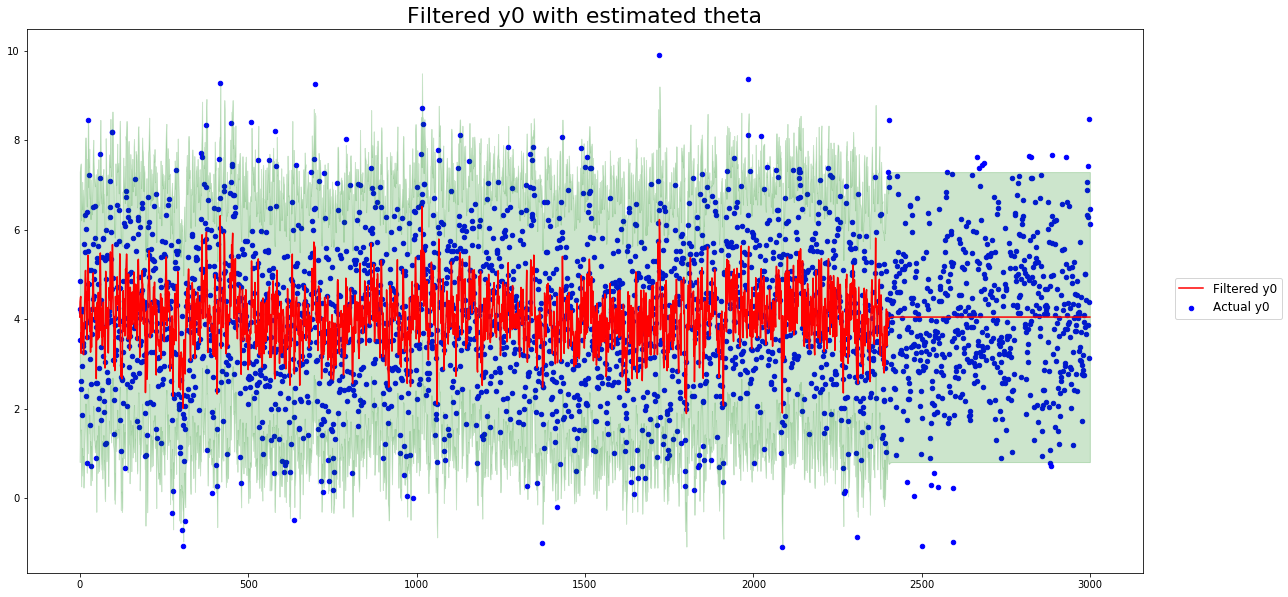

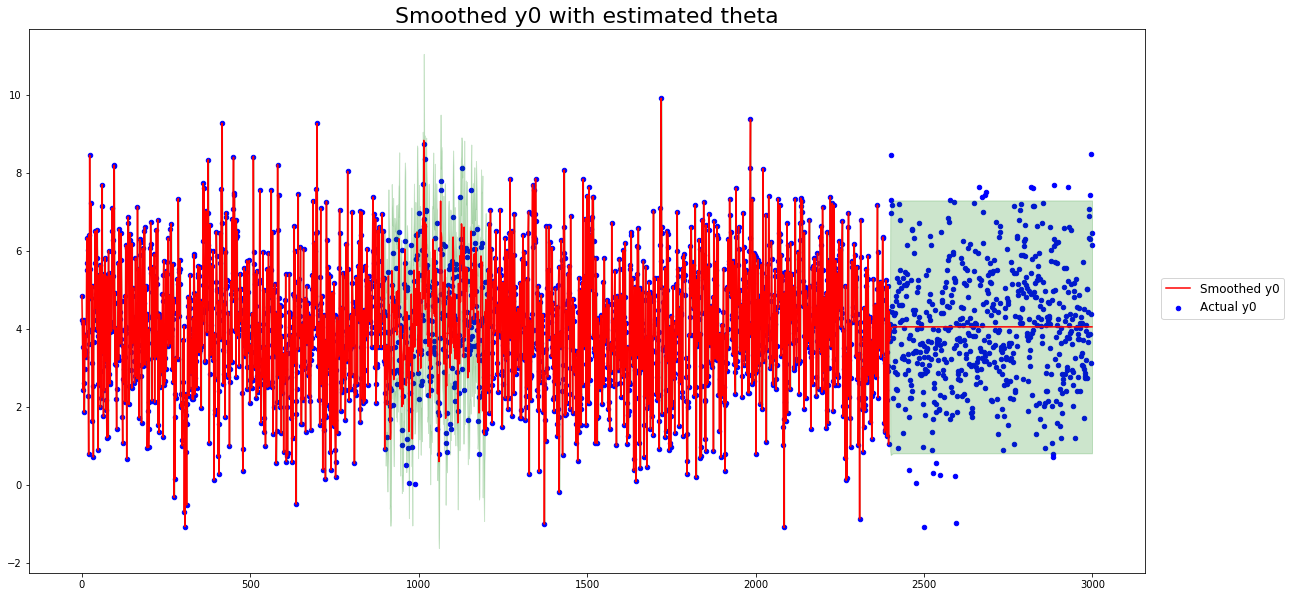

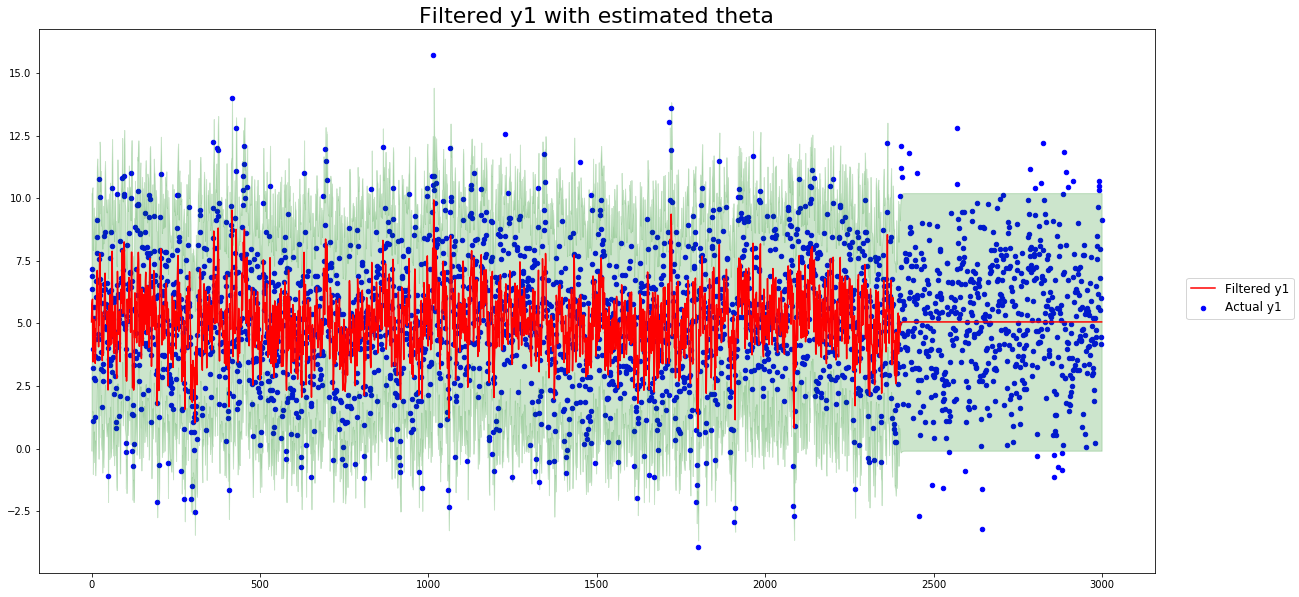

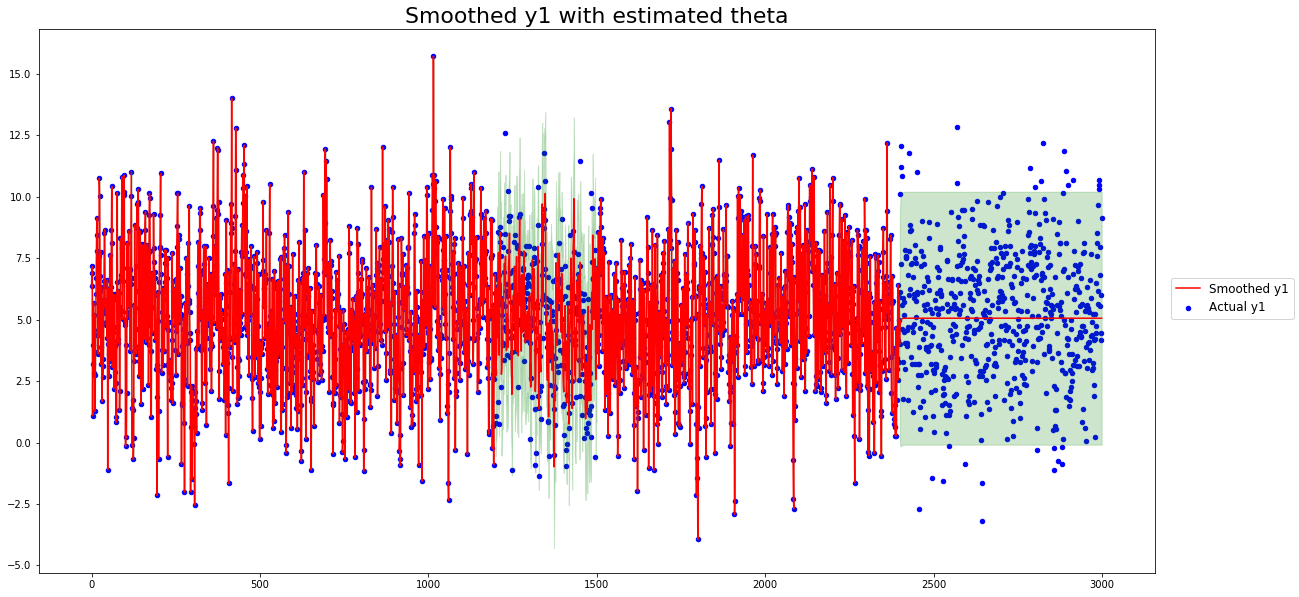

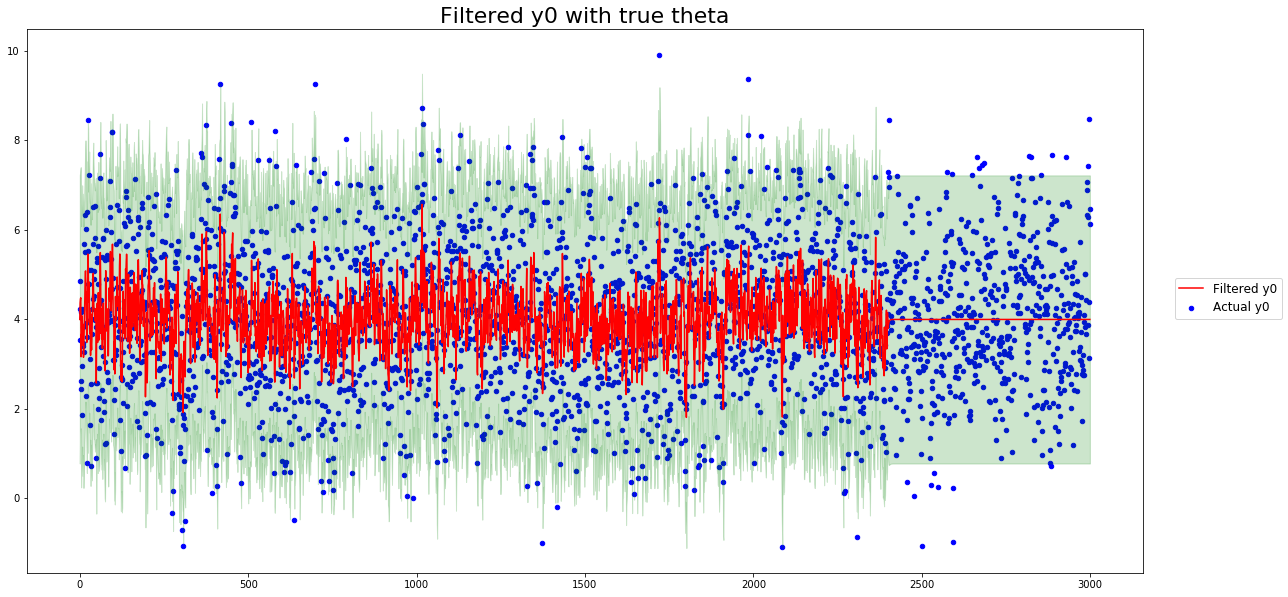

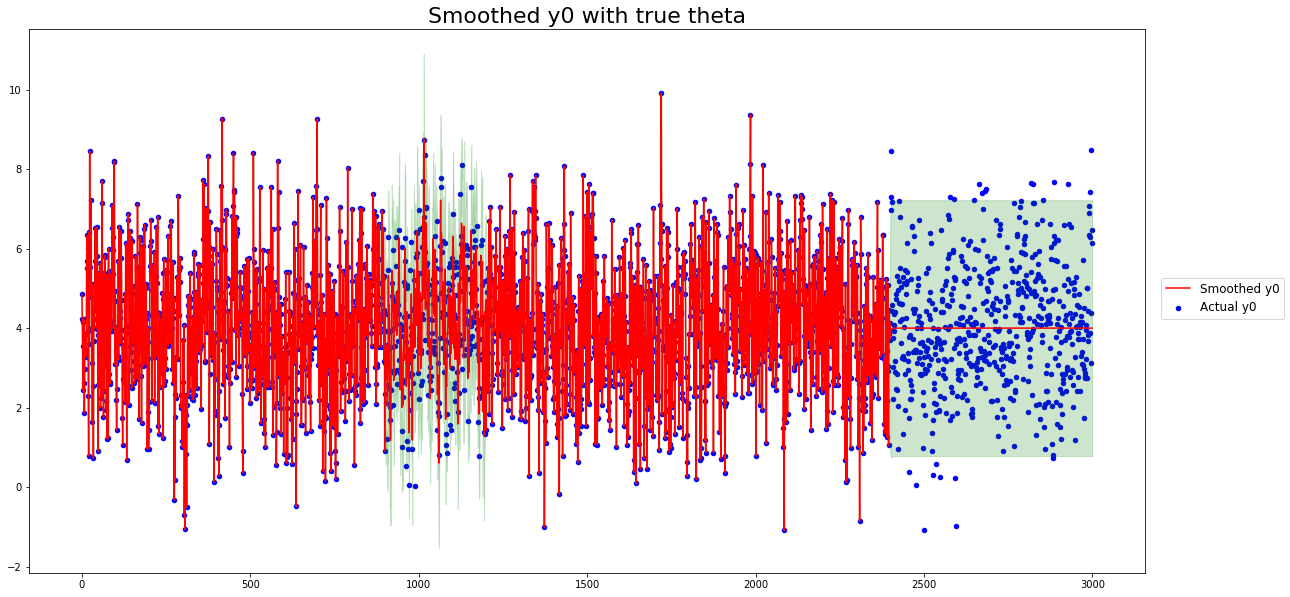

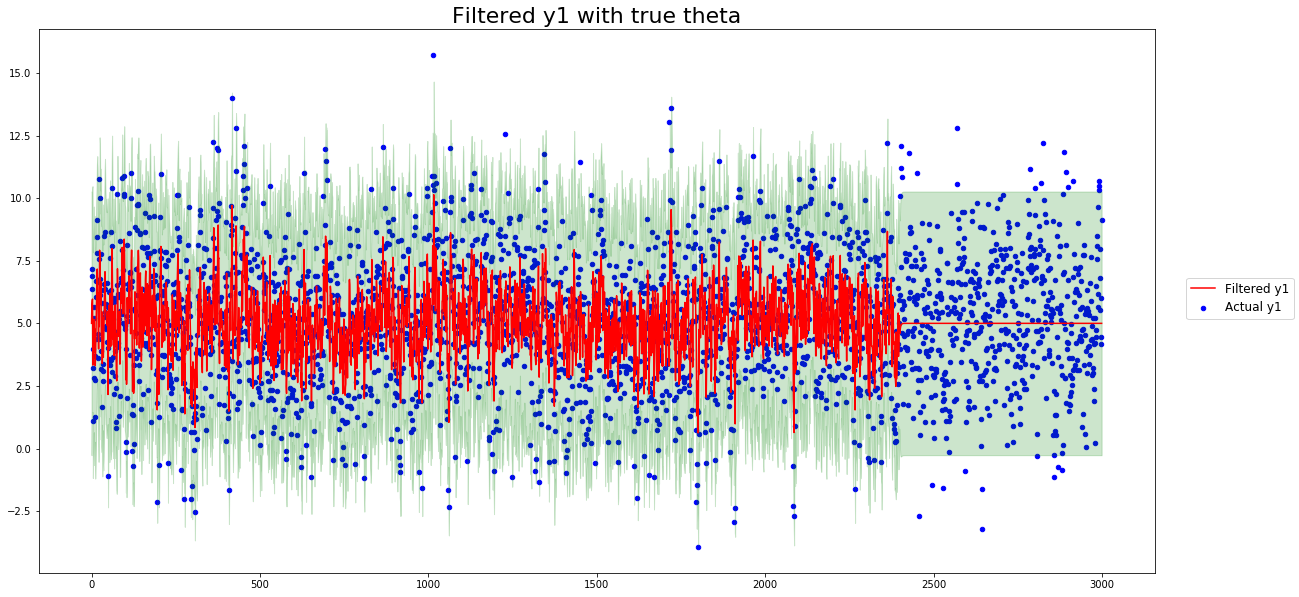

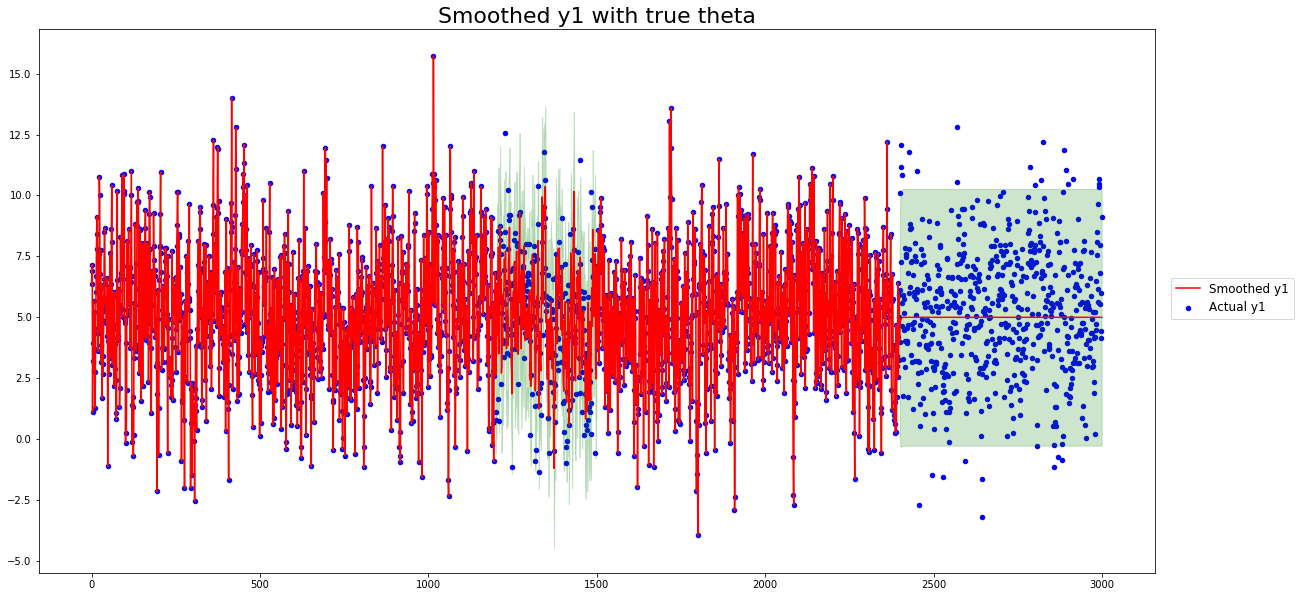

In [8]:
# y_0_t with estimated theta
simple_plot(df_LLY, 'y_0_filtered', 'y_0_vis', 'yf0_ub', 'yf0_lb', 'Filtered y0', 'Actual y0',
           'Filtered y0 with estimated theta')
simple_plot(df_LLY, 'y_0_smoothed', 'y_0_vis', 'ys0_ub', 'ys0_lb', 'Smoothed y0', 'Actual y0',
           'Smoothed y0 with estimated theta')

# y_1_t with estimated theta
simple_plot(df_LLY, 'y_1_filtered', 'y_1_vis', 'yf1_ub', 'yf1_lb', 'Filtered y1', 'Actual y1',
           'Filtered y1 with estimated theta')
simple_plot(df_LLY, 'y_1_smoothed', 'y_1_vis', 'ys1_ub', 'ys1_lb', 'Smoothed y1', 'Actual y1',
           'Smoothed y1 with estimated theta')

# y_0_t with true theta
simple_plot(df_true, 'y_0_filtered', 'y_0_vis', 'yf0_ub', 'yf0_lb', 'Filtered y0', 'Actual y0',
           'Filtered y0 with true theta')
simple_plot(df_true, 'y_0_smoothed', 'y_0_vis', 'ys0_ub', 'ys0_lb', 'Smoothed y0', 'Actual y0',
           'Smoothed y0 with true theta')

# y_1_t with true theta
simple_plot(df_true, 'y_1_filtered', 'y_1_vis', 'yf1_ub', 'yf1_lb', 'Filtered y1', 'Actual y1',
           'Filtered y1 with true theta')
simple_plot(df_true, 'y_1_smoothed', 'y_1_vis', 'ys1_ub', 'ys1_lb', 'Smoothed y1', 'Actual y1',
           'Smoothed y1 with true theta')

In [9]:
# Build a simple function
def summary_stats(df, col_est, col_true):
    RMSE = np.sqrt((df[col_est] - df[col_true]).var())
    mean_error = (df[col_est] - df[col_true]).mean()
    return {'RMSE': RMSE, 'mean_error': mean_error}

In [10]:
# Compare model performance in training data
print('LLY theta for training data: {}'.format(
    summary_stats(df_LLY[is_train], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for training data: {}'.format(
    summary_stats(df_true[is_train], 'y_0_filtered', 'y_0_vis')))
print('LLY theta for training data: {}'.format(
    summary_stats(df_LLY[is_train], 'y_1_filtered', 'y_1_vis')))
print('Ture theta for training data: {}'.format(
    summary_stats(df_true[is_train], 'y_1_filtered', 'y_1_vis')))
print('LLY theta for training data (smoothed): {}'.format(
    summary_stats(df_LLY[is_train], 'y_0_smoothed', 'y_0_vis')))
print('Ture theta for training data (smoothed): {}'.format(
    summary_stats(df_true[is_train], 'y_0_smoothed', 'y_0_vis')))
print('LLY theta for training data (smoothed): {}'.format(
    summary_stats(df_LLY[is_train], 'y_1_smoothed', 'y_1_vis')))
print('Ture theta for training data (smoothed): {}'.format(
    summary_stats(df_true[is_train], 'y_1_smoothed', 'y_1_vis')))

LLY theta for training data: {'RMSE': 1.516585453312651, 'mean_error': 0.013667660874484957}
Ture theta for training data: {'RMSE': 1.5172327956971328, 'mean_error': -0.021447277144973364}
LLY theta for training data: {'RMSE': 2.3000414125644832, 'mean_error': -0.00792610909962158}
Ture theta for training data: {'RMSE': 2.301424736322943, 'mean_error': -0.028901153984790234}
LLY theta for training data (smoothed): {'RMSE': 0.4003344652514089, 'mean_error': 0.013007373305217017}
Ture theta for training data (smoothed): {'RMSE': 0.3994357443150293, 'mean_error': 0.009143803588654418}
LLY theta for training data (smoothed): {'RMSE': 0.605897931154198, 'mean_error': -0.0092295204870714}
Ture theta for training data (smoothed): {'RMSE': 0.6051525922531039, 'mean_error': -0.00511516466375347}


In [11]:
# Compare model performance in test data
print('LLY theta for test data: {}'.format(
    summary_stats(df_LLY[is_test], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for test data: {}'.format(
    summary_stats(df_true[is_test], 'y_0_filtered', 'y_0_vis')))
print('LLY theta for test data: {}'.format(
    summary_stats(df_LLY[is_test], 'y_1_filtered', 'y_1_vis')))
print('Ture theta for test data: {}'.format(
    summary_stats(df_true[is_test], 'y_1_filtered', 'y_1_vis')))

LLY theta for test data: {'RMSE': 1.4725526516809833, 'mean_error': 0.022838892583475854}
Ture theta for test data: {'RMSE': 1.4749688769562346, 'mean_error': -0.01152361393720432}
LLY theta for test data: {'RMSE': 2.304398208145796, 'mean_error': -0.11279701074527584}
Ture theta for test data: {'RMSE': 2.306924487053599, 'mean_error': -0.13058639659470406}


In [12]:
# Compare model performance in forecast data
print('LLY theta for forecast data: {}'.format(
    summary_stats(df_LLY[is_forecast], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for forecast data: {}'.format(
    summary_stats(df_true[is_forecast], 'y_0_filtered', 'y_0_vis')))
print('LLY theta for forecast data: {}'.format(
    summary_stats(df_LLY[is_forecast], 'y_1_filtered', 'y_1_vis')))
print('Ture theta for forecast data: {}'.format(
    summary_stats(df_true[is_forecast], 'y_1_filtered', 'y_1_vis')))

LLY theta for forecast data: {'RMSE': 1.5528457474687098, 'mean_error': -0.004918155677144907}
Ture theta for forecast data: {'RMSE': 1.5528145599015493, 'mean_error': -0.058051029915753304}
LLY theta for forecast data: {'RMSE': 2.608191746514063, 'mean_error': -0.16577339531240753}
Ture theta for forecast data: {'RMSE': 2.608146949889953, 'mean_error': -0.2227887671944508}
